In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
data_dir = "C:/Users/HARSHIT/Desktop/Harshit files/IITD/Sem8/ELL409/Project_ImageClassification/Image/4"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [5]:
# Define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)), #input size expected by ResNet.
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], #ImageNet's RGB channel statistics- chanel wise normalise the data, use these values as 
                             [0.229, 0.224, 0.225]) #our dataset is small
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [6]:
# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']), #automatically reads images from folders assuming folder names = class labels.
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

In [7]:
image_datasets['train'].class_to_idx

{'Ibizan_hound': 0,
 'aircraft_carrier': 1,
 'beer_bottle': 2,
 'bolete': 3,
 'boxer': 4,
 'carton': 5,
 'dome': 6,
 'electric_guitar': 7,
 'file': 8,
 'french_bulldog': 9,
 'garbage_truck': 10,
 'golden_retriever': 11,
 'gordon_setter': 12,
 'hair_slide': 13,
 'hourglass': 14,
 'house_finch': 15,
 'komondor': 16,
 'malamute': 17,
 'meerkat': 18,
 'pencil_box': 19,
 'prayer_rug': 20,
 'reel': 21,
 'rock_beauty': 22,
 'scoreboard': 23,
 'solar_dish': 24,
 'stage': 25,
 'street_sign': 26,
 'tank': 27,
 'tile_roof': 28,
 'tobacco_shop': 29,
 'trifle': 30,
 'white_wolf': 31,
 'yawl': 32}

In [8]:
#without applying transformations
print(image_datasets['train'].__len__()) #33x400 examples
img_tensor, label=image_datasets['train'][400]
img_tensor.shape, label

13200


(torch.Size([3, 224, 224]), 1)

In [9]:
#applying transformations
print(image_datasets['train'].__len__()) #33x400 examples
img_tensor, label=image_datasets['train'][0]
img_tensor.shape, label

13200


(torch.Size([3, 224, 224]), 0)

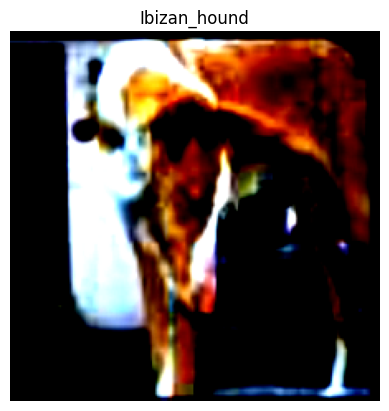

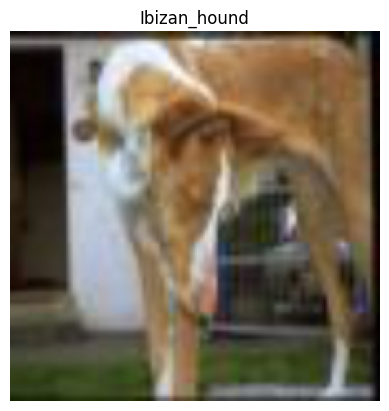

(None, None)

In [10]:
def imshow(img, unnormalise=0):
    img = img.numpy().transpose((1, 2, 0))  # C,H,W → H,W,C
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    if(unnormalise):img = std * img + mean  # unnormalise
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_datasets['train'].classes[label])
    plt.show()

imshow(img_tensor), imshow(img_tensor,1)

In [11]:
# Create dataloaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

In [12]:
print(dataloaders['train'].__len__()) # ~33*400/32

413


In [13]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

c:\Users\HARSHIT\anaconda3\envs\Project_CNN\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HARSHIT\anaconda3\envs\Project_CNN\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
num_classes= image_datasets['train'].classes.__len__()
print(num_classes)
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# model.fc = nn.Linear(model.fc.in_features, num_classes)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)


model = model.to(device)

33


In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() #applies softmax internally for converting to probabilites and uses -log likelihood
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 20
best_acc = 0.0

In [16]:
from torchsummary import summary
# Print summary: (input size should match image size, here 3×224×224)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0 #Accumulates total loss across all samples in the current phase
        running_corrects = 0 #Counts how many predictions were correct in the current batch

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs) #tensor of size [batch size, num_classes]
                _, preds = torch.max(outputs, 1)
                #_ = max score (no use)
                #preds = index of max score = predicted class label
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0) #loss.item() gives average loss for the batch
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase]) 
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

Epoch 1/20
----------
train Loss: 1.0577 Acc: 0.7133
val Loss: 0.6015 Acc: 0.8273
Epoch 2/20
----------
train Loss: 0.6384 Acc: 0.8133
val Loss: 0.5959 Acc: 0.8294
Epoch 3/20
----------
train Loss: 0.5774 Acc: 0.8303
val Loss: 0.5834 Acc: 0.8348
Epoch 4/20
----------
train Loss: 0.5500 Acc: 0.8348
val Loss: 0.5422 Acc: 0.8373
Epoch 5/20
----------
train Loss: 0.5364 Acc: 0.8386
val Loss: 0.5426 Acc: 0.8470
Epoch 6/20
----------
train Loss: 0.5102 Acc: 0.8474
val Loss: 0.5579 Acc: 0.8470
Epoch 7/20
----------
train Loss: 0.5051 Acc: 0.8487
val Loss: 0.5196 Acc: 0.8494
Epoch 8/20
----------
train Loss: 0.4927 Acc: 0.8523
val Loss: 0.5296 Acc: 0.8445
Epoch 9/20
----------
train Loss: 0.4887 Acc: 0.8535
val Loss: 0.5628 Acc: 0.8391
Epoch 10/20
----------
train Loss: 0.4664 Acc: 0.8582
val Loss: 0.5907 Acc: 0.8418
Epoch 11/20
----------
train Loss: 0.4581 Acc: 0.8613
val Loss: 0.5565 Acc: 0.8488
Epoch 12/20
----------
train Loss: 0.4415 Acc: 0.8676
val Loss: 0.5882 Acc: 0.8458
Epoch 13/20
-

Epoch 1/20
train Loss: 0.9178 Acc: 0.7791
val Loss: 0.5773 Acc: 0.8364

Epoch 2/20
train Loss: 0.4644 Acc: 0.8663
val Loss: 0.5238 Acc: 0.8491

Epoch 3/20
train Loss: 0.4079 Acc: 0.8770
val Loss: 0.5252 Acc: 0.8442

Epoch 4/20
train Loss: 0.3819 Acc: 0.8847
val Loss: 0.5414 Acc: 0.8473

Epoch 5/20
train Loss: 0.3567 Acc: 0.8921
val Loss: 0.4953 Acc: 0.8630

Epoch 6/20
train Loss: 0.3323 Acc: 0.8955
val Loss: 0.5525 Acc: 0.8494

Epoch 7/20
train Loss: 0.3245 Acc: 0.8973
val Loss: 0.5116 Acc: 0.8524

Epoch 8/20
train Loss: 0.3196 Acc: 0.8986
val Loss: 0.6080 Acc: 0.8385

Epoch 9/20
train Loss: 0.3070 Acc: 0.9042
val Loss: 0.6433 Acc: 0.8430

Epoch 10/20
train Loss: 0.2825 Acc: 0.9121
val Loss: 0.6448 Acc: 0.8327

Epoch 11/20
train Loss: 0.2800 Acc: 0.9089
val Loss: 0.6114 Acc: 0.8433

Epoch 12/20
train Loss: 0.2786 Acc: 0.9120
val Loss: 0.6394 Acc: 0.8412

Epoch 13/20
train Loss: 0.2662 Acc: 0.9123
val Loss: 0.6200 Acc: 0.8442

Epoch 14/20
train Loss: 0.2687 Acc: 0.9134
val Loss: 0.6015 Acc: 0.8494

Epoch 15/20
train Loss: 0.2548 Acc: 0.9173
val Loss: 0.6518 Acc: 0.8415

Epoch 16/20
train Loss: 0.2547 Acc: 0.9167
val Loss: 0.5806 Acc: 0.8524

Epoch 17/20
train Loss: 0.2492 Acc: 0.9189
val Loss: 0.6378 Acc: 0.8452

Epoch 18/20
train Loss: 0.2414 Acc: 0.9196
val Loss: 0.6622 Acc: 0.8400

Epoch 19/20
train Loss: 0.2387 Acc: 0.9217
val Loss: 0.6780 Acc: 0.8436

Epoch 20/20
train Loss: 0.2315 Acc: 0.9254
val Loss: 0.6485 Acc: 0.8418

In [18]:
# Evaluation on test data
model.eval()
running_corrects = 0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / len(image_datasets['test'])
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8673


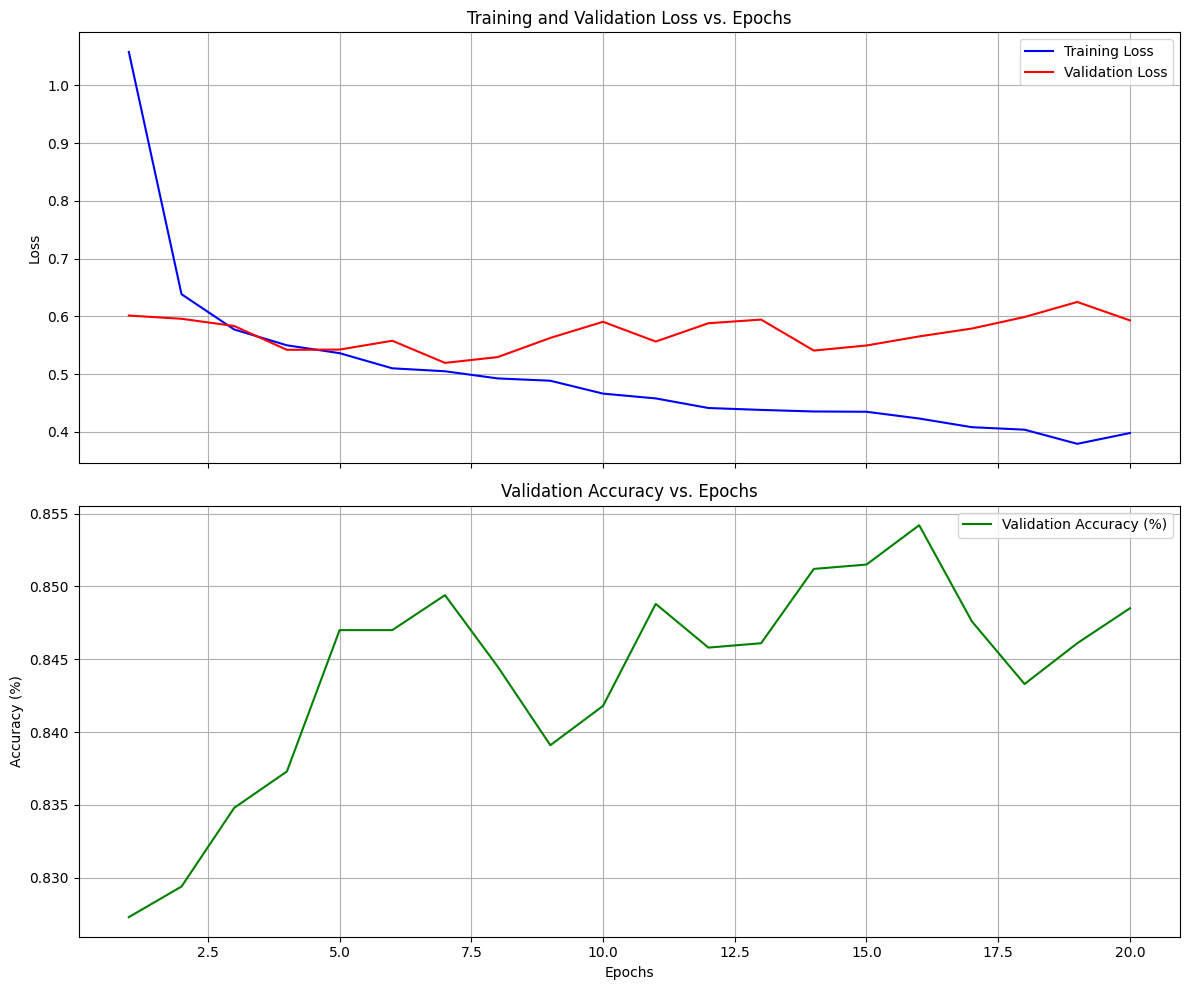

Initial train loss: 1.0577, Final train loss: 0.3982
Initial val loss: 0.6015, Final val loss: 0.5931
Initial val accuracy: 0.83%, Final val accuracy: 0.85%
Best validation accuracy: 0.85% (Epoch 16)
Best validation loss: 0.5196 (Epoch 7)


In [1]:
# Create a new cell with this code
import matplotlib.pyplot as plt
import numpy as np
import re

# Extract data from log output
log_lines = """
Epoch 1/20 - Train Loss: 1.0577 | Val Loss: 0.6015 | Val Acc: 0.8273
Epoch 2/20 - Train Loss: 0.6384 | Val Loss: 0.5959 | Val Acc: 0.8294
Epoch 3/20 - Train Loss: 0.5774 | Val Loss: 0.5834 | Val Acc: 0.8348
Epoch 4/20 - Train Loss: 0.5500 | Val Loss: 0.5422 | Val Acc: 0.8373
Epoch 5/20 - Train Loss: 0.5364 | Val Loss: 0.5426 | Val Acc: 0.8470
Epoch 6/20 - Train Loss: 0.5102 | Val Loss: 0.5579 | Val Acc: 0.8470
Epoch 7/20 - Train Loss: 0.5051 | Val Loss: 0.5196 | Val Acc: 0.8494
Epoch 8/20 - Train Loss: 0.4927 | Val Loss: 0.5296 | Val Acc: 0.8445
Epoch 9/20 - Train Loss: 0.4887 | Val Loss: 0.5628 | Val Acc: 0.8391
Epoch 10/20 - Train Loss: 0.4664 | Val Loss: 0.5907 | Val Acc: 0.8418
Epoch 11/20 - Train Loss: 0.4581 | Val Loss: 0.5565 | Val Acc: 0.8488
Epoch 12/20 - Train Loss: 0.4415 | Val Loss: 0.5882 | Val Acc: 0.8458
Epoch 13/20 - Train Loss: 0.4382 | Val Loss: 0.5945 | Val Acc: 0.8461
Epoch 14/20 - Train Loss: 0.4355 | Val Loss: 0.5409 | Val Acc: 0.8512
Epoch 15/20 - Train Loss: 0.4350 | Val Loss: 0.5497 | Val Acc: 0.8515
Epoch 16/20 - Train Loss: 0.4233 | Val Loss: 0.5654 | Val Acc: 0.8542
Epoch 17/20 - Train Loss: 0.4083 | Val Loss: 0.5790 | Val Acc: 0.8476
Epoch 18/20 - Train Loss: 0.4040 | Val Loss: 0.5990 | Val Acc: 0.8433
Epoch 19/20 - Train Loss: 0.3795 | Val Loss: 0.6250 | Val Acc: 0.8461
Epoch 20/20 - Train Loss: 0.3982 | Val Loss: 0.5931 | Val Acc: 0.8485
"""

# Extract train loss, validation loss and accuracy
train_losses = []
val_losses = []
val_accs = []
epochs = []

# Process each line to extract information
for line in log_lines.strip().split('\n'):
    match = re.search(r"Epoch (\d+)/\d+ - Train Loss: (\d+\.\d+) \| Val Loss: (\d+\.\d+) \| Val Acc: (\d+\.\d+)", line)
    if match:
        epoch = int(match.group(1))
        train_loss = float(match.group(2))
        val_loss = float(match.group(3))
        val_acc = float(match.group(4))
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

# Create figure with two subplots: one for losses, one for accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot the losses
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss vs. Epochs')
ax1.legend()
ax1.grid(True)

# Plot the validation accuracy
ax2.plot(epochs, val_accs, 'g-', label='Validation Accuracy (%)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy vs. Epochs')
ax2.legend()
ax2.grid(True)

# Add some margins to the figure
plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300)
plt.show()

# Print statistics
print(f"Initial train loss: {train_losses[0]:.4f}, Final train loss: {train_losses[-1]:.4f}")
print(f"Initial val loss: {val_losses[0]:.4f}, Final val loss: {val_losses[-1]:.4f}")
print(f"Initial val accuracy: {val_accs[0]:.2f}%, Final val accuracy: {val_accs[-1]:.2f}%")
print(f"Best validation accuracy: {max(val_accs):.2f}% (Epoch {epochs[val_accs.index(max(val_accs))]})")
print(f"Best validation loss: {min(val_losses):.4f} (Epoch {epochs[val_losses.index(min(val_losses))]})")